<a href="https://colab.research.google.com/github/zizi1532/NaiveBayesClassifier/blob/master/imdb_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment on IMDB dataset using Naive Bayes Classifier

#### 1. Task: sentiment analysis where given a review we predict rating for the review
#### 2. Dataset: IMDB, movie review dataset (rating ranging from 1 to 10)
#### 3. Method: Naive Bayes Classifier

## Load Dataset

In [0]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
data_dir = "/content/drive/My Drive/Colab Notebooks/imdb_dataset/"

Mounted at /content/drive


In [0]:
import numpy as np
def load_data(data_dir, dtype):
    data = open(data_dir+'imdb.{}.txt.ss'.format(dtype)).read().split("\n")[:-1]
    user_id, product_id, rating, review = list(zip(*[x.split("\t\t") for x in data]))
    review = [x.split() for x in review]
    # binarize ratings
    rating = np.array([int(x) for x in rating], dtype=np.int64)
    binary_rating = (rating>5).astype(np.int64) # 1,2,3,4,5=negative / 6,7,8,9,10=positive
    print("The number of \"{}\" instances: {}".format(dtype, len(review)))
    return review, binary_rating
n_classes = 2
X_train, Y_train = load_data(data_dir=data_dir, dtype='train')
X_dev, Y_dev = load_data(data_dir=data_dir, dtype='dev')
X_test, Y_test = load_data(data_dir=data_dir, dtype='test')

The number of "train" instances: 67426
The number of "dev" instances: 8381
The number of "test" instances: 9112


In [0]:
X_train[0][:10] + ['...']

['i', 'excepted', 'a', 'lot', 'from', 'this', 'movie', ',', 'and', 'it', '...']

In [0]:
Y_train

array([1, 0, 1, ..., 1, 1, 1])

## Preprocessing reviews - constructing vocabulary

In [0]:
from collections import Counter
from itertools import chain
def preprocess_vocab(train_texts, _vocab_size=None, ptr=True):
    word_count = Counter(chain(*train_texts))
    if ptr:    
        print("Most frequent words: \n", 
              list(zip(*word_count.most_common(10)))[0])
        print("The number of words: ", len(word_count))
    # Select top-K most frequent words
    if _vocab_size:
        _vocab = set(list(zip(*word_count.most_common(_vocab_size)))[0])
    else:
        _vocab = set(list(word_count.keys()))
    return _vocab

In [0]:
vocab = preprocess_vocab(X_train, ptr=True)
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}
n_vocab = len(vocab)

Most frequent words: 
 ('the', ',', '<sssss>', '.', 'and', 'a', 'of', 'to', 'is', 'in')
The number of words:  90060


In [0]:
!pip install tqdm

In [0]:
# Now we reconstruct input review using predefined vocabulary
from tqdm import tqdm_notebook as tqdm # !pip install tqdm
def reconstruct_review(_reviews, _vocab, _word2idx, _tqdm=True):
    iterator = tqdm(_reviews) if _tqdm else _reviews
    return [
        np.array([_word2idx[word] for word in set(_review) if word in _vocab], dtype=np.int64)
        for _review in iterator
    ]

In [0]:
X_train_proc = reconstruct_review(X_train, vocab, word2idx)
X_dev_proc = reconstruct_review(X_dev, vocab, word2idx)
X_test_proc = reconstruct_review(X_test, vocab, word2idx)

In [0]:
" / ".join(X_train[0][:10])

'i / excepted / a / lot / from / this / movie / , / and / it'

In [0]:
X_train_proc[0], " / ".join([idx2word[i] for i in X_train_proc[0]][:10])

(array([73250, 51729, 39871, 83336,  8805, 48986, 43522, 52247, 51491,
        16341,  6667, 30608,  3474, 10066, 86488,  8765, 37281, 84704,
        22112, 15373, 24987,  9126, 80065, 50468, 45956,  4359, 29617,
        14714, 77076, 25714,  7383, 36280, 75615, 51803, 35979, 71611,
        63817, 41240, 88349, 32685, 35539, 59040, 55703, 71338, 23350,
        86651,  6815, 33106, 27409, 89606, 41954, 42303, 56747, 32652,
        77646, 20886, 20788, 33206, 65653, 14311, 60242, 67684, 84357,
        37836,  1490, 62013, 25659, 16978, 72247, 83908, 68091]),
 'all / poor / by / really / not / . / always / film / this / did')

## Applying Naive Bayes Classifier
### 1. Prior
### 2. Likelihood
### 3. Posterior
* Note that prior and likelihood are estimated using train datset and posterior is estimated on test datset 

In [0]:
def calculate_prior(_ratings, ptr=True):
    _prior = np.array([
        (_ratings==i).sum() for i in range(n_classes)
    ], dtype=np.float32)
    if ptr:
        print("\n".join(
            [
                "The number of training instance for {}'th class: {}".format(
                i, int(_prior[i])
                ) 
                for i in range(n_classes)
            ]))
        print("Total number of training instances: {}".format(int(sum(_prior))))
    _prior /= _prior.sum()
    return _prior
prior = calculate_prior(Y_train)
prior

The number of training instance for 0'th class: 14938
The number of training instance for 1'th class: 52488
Total number of training instances: 67426


array([0.22154659, 0.7784534 ], dtype=float32)

In [0]:
def calculate_likelihood(_reviews, _ratings, _vocab, smoothing_constant=1, _tqdm=True):
    # 1. Declare/Instantiate likelihood dictionary
    word_count = np.zeros((n_classes, n_vocab), dtype=np.float32)
    word_count += smoothing_constant # Laplace smoothing
   
    # 2. Count the number of words conditioned on each class
    iterator = tqdm(zip(_reviews, _ratings), total=len(_reviews))\
    if _tqdm else zip(_reviews, _ratings)
    for X, Y in iterator: word_count[Y][X]+=1

    # 3. Normalize counts and calculate log-likelihood
    # --: log p(w|y) = log [count(w,y)] - log [\sum_{w'\in V}count(w', y)]
    norm = np.log(word_count.sum(-1, keepdims=True))
    _loglikelihood = np.log(word_count) - norm
    return _loglikelihood

In [0]:
loglikelihood = calculate_likelihood(X_train_proc, Y_train, vocab, _tqdm=False)
"Make sure the probability distribution sums to one: ", np.exp(loglikelihood).sum(-1)

('Make sure the probability distribution sums to one: ',
 array([1.0000002, 1.0000008], dtype=float32))

In [0]:
# Now we have prior, p(y), and log-likelihood, log[p(w|y)].
# Using bayes rule and conditional independence assumption, 
# we can estimate posterior distribution p(y|x),
# , and then we can classify reviews.
def naive_bayes_classifier(_reviews, _loglikelihood, _prior):
    predicted_class = []
    log_prior = np.log(_prior)
    for _review in _reviews:
        # 1. Calculate posterior
        _posterior = log_prior + _loglikelihood[:, _review].sum(-1)
        # 2. Arg-max operation
        predicted_class.append(np.argmax(_posterior))
    return np.array(predicted_class, dtype=np.int64)

## Evaluation

In [0]:
Y_pred_test = naive_bayes_classifier(X_test_proc, loglikelihood, prior)
(Y_pred_test==Y_test).mean()*100

82.16637401229148

### Baselines

In [0]:
Y_random = np.random.choice([0,1], size=len(Y_test), p=[prior[0], prior[1]])
Y_one = [1]*len(Y_test)
(Y_random==Y_test).mean()*100, \
(Y_one==Y_test).mean()*100, \

(65.4521510096576, 77.29367866549605)

### Ablation study on Laplace smoothing constant

In [0]:
def search_smoothing_constant(candidates):
  accuracy_train = []
  accuracy_dev = []
  for smoothing_constant in candidates:
      loglikelihood = calculate_likelihood(X_train_proc, Y_train, vocab, smoothing_constant, _tqdm=False)
      Y_pred_train = naive_bayes_classifier(X_train_proc, loglikelihood, prior)
      Y_pred_dev = naive_bayes_classifier(X_dev_proc, loglikelihood, prior)
      print("Smoothing Constant: {} ====> Accuracy: train {:2.3f}%, dev {:2.3f}%".format(
          smoothing_constant,
          (Y_pred_train==Y_train).mean()*100,
          (Y_pred_dev==Y_dev).mean()*100,
      ))
      accuracy_train.append((Y_pred_train==Y_train).mean()*100)
      accuracy_dev.append((Y_pred_dev==Y_dev).mean()*100)
  %matplotlib inline
  from matplotlib import pyplot as plt
  import seaborn as sns
  sns.set_style("whitegrid")
  num_experiment = len(candidates)
  # plt.figure(figsize=(int(num_experiment/2), int(num_experiment/4)))
  plt.plot(accuracy_train, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=5, label='train')
  plt.plot(accuracy_dev, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=5, label='dev')
  plt.legend(prop={'size':25})
  plt.xticks(fontsize=14, rotation=-45)
  plt.yticks(fontsize=14)
  plt.xticks(range(num_experiment), candidates)
  plt.xlabel('Smoothing Constant', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)

Smoothing Constant: 1 ====> Accuracy: train 85.827%, dev 81.709%
Smoothing Constant: 2 ====> Accuracy: train 87.601%, dev 83.940%
Smoothing Constant: 3 ====> Accuracy: train 88.165%, dev 85.169%
Smoothing Constant: 4 ====> Accuracy: train 87.677%, dev 85.503%
Smoothing Constant: 5 ====> Accuracy: train 86.281%, dev 84.715%
Smoothing Constant: 6 ====> Accuracy: train 84.493%, dev 83.296%
Smoothing Constant: 7 ====> Accuracy: train 82.695%, dev 81.804%
Smoothing Constant: 8 ====> Accuracy: train 81.188%, dev 80.766%
Smoothing Constant: 9 ====> Accuracy: train 80.069%, dev 80.038%
Smoothing Constant: 10 ====> Accuracy: train 79.205%, dev 79.489%


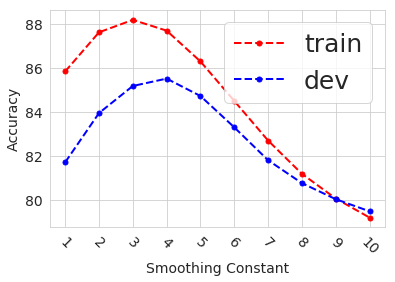

In [0]:
search_smoothing_constant(candidates=list(range(1, 11)))

In [0]:
(
    (
        naive_bayes_classifier(
          X_test_proc, 
          calculate_likelihood(X_train_proc, Y_train, vocab, smoothing_constant=1, _tqdm=False), 
          prior
        )==Y_test
    ).mean()*100,
    (
        naive_bayes_classifier(
          X_test_proc, 
          calculate_likelihood(X_train_proc, Y_train, vocab, smoothing_constant=3.6, _tqdm=False), 
          prior
        )==Y_test
    ).mean()*100,
)

(82.16637401229148, 85.4367866549605)

### Analysis on most distinctive words

In [0]:
loglikelihood = calculate_likelihood(X_train_proc, Y_train, vocab, smoothing_constant=4, _tqdm=False)

# argmax_{w} log p(w|y)
K = 20
topK_likely_words = np.argsort(loglikelihood, axis=-1)[:, ::-1][:, :K]
print("""
Most likely words given a rating, i.e., argmax_w p(w|y)
negative words: {}
positive words: {}
""".format(
    ", ".join([idx2word[i] for i in topK_likely_words[0]]),
    ", ".join([idx2word[i] for i in topK_likely_words[1]])
)+"\n"+"This does not exclude commonly frequent words\n"+"*"*50)

# argmax_{w} log p(y|w) = log p(w|y) + log p(y) - \log p(w)
#  >> "log p(w|y) - \log p(w)"
# p(w)=\sum_{y} p(w|y)p(y)
word_marginalized_dist = (np.exp(loglikelihood)*prior.reshape(-1,1)).sum(0)
word_posterior = loglikelihood+np.log(prior).reshape(-1, 1)-np.log(word_marginalized_dist).reshape(1, -1)
K = 20
topK_indicative_words = np.argsort(word_posterior, axis=-1)[:, ::-1][:, :K]
print("""
On the other hand, posterior excludes those: argmax_w log p(y|w) = log p(w|y) - \log p(w) + C
Most indicative words based on posterior
negative words: {}
positive words: {}
""".format(
    ", ".join([idx2word[i] for i in topK_indicative_words[0]]),
    ", ".join([idx2word[i] for i in topK_indicative_words[1]])
))


def show_posterior(_words):
  for _w in _words:
      print("Posterior given \"{:12s}\": [{}]".format(
          _w, 
          ", ".join([str("{:0.3f}".format(x)) for x in np.exp(word_posterior[:, word2idx[_w]])])
      ))
  print("")
show_posterior(["good", "great", "interesting"])
show_posterior(["worst", "boring"])


Most likely words given a rating, i.e., argmax_w p(w|y)
negative words: the, ., <sssss>, a, ,, and, of, to, is, in, it, this, that, but, 's, with, for, i, as, n't
positive words: the, ., <sssss>, a, and, ,, of, to, is, in, it, this, that, 's, with, but, for, as, i, on

This does not exclude commonly frequent words
**************************************************

On the other hand, posterior excludes those: argmax_w log p(y|w) = log p(w|y) - \log p(w) + C
Most indicative words based on posterior
negative words: 5/10, 2/10, 3/10, 4/10, 1/10, carnby, 0/10, dropo, yawns, terl, uninspiring, uwe, proske, mcelhone, hobgoblins, boll, mst3k, kimar, kool-aid, goodboy
positive words: 8/10, 9/10, 10/10, 7.5, 8.5, 7/10, 6.5, sorbonne, maltese, 6/10, coulardeau, marvelous, 9.5, cazale, rhys-davies, shire, brilliantly, unforgettable, richly, ennio

Posterior given "good        ": [0.210, 0.790]
Posterior given "great       ": [0.135, 0.865]
Posterior given "interesting ": [0.227, 0.773]

Posterio

# Using sklearn

In [2]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
data_dir = "/content/drive/My Drive/Colab Notebooks/imdb_dataset/"
def load_data(data_dir, dtype):
    data = open(data_dir+'imdb.{}.txt.ss'.format(dtype)).read().split("\n")[:-1]
    _, _, rating, review = list(zip(*[x.split("\t\t") for x in data]))
    return review, rating
X_train, Y_train = load_data(data_dir=data_dir, dtype='train')
X_test, Y_test = load_data(data_dir=data_dir, dtype='test')
X_train[0], Y_train[0]

Mounted at /content/drive


('i excepted a lot from this movie , and it did deliver . <sssss> there is some great buddhist wisdom in this movie . <sssss> the real dalai lama is a very interesting person , and i think there is a lot of wisdom in buddhism . <sssss> the music , of course , sounds like because it is by philip glass . <sssss> this adds to the beauty of the movie . <sssss> whereas other biographies of famous people tend to get very poor this movie always stays focused and gives a good and honest portrayal of the dalai lama . <sssss> all things being equal , it is a great movie , and i really enjoyed it . <sssss> it is not like taxi driver of course but as a biography of a famous person it is really a great film indeed . ',
 '10')

### (Multinomial) Naive Bayes Classifier

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [0]:
vocab = set()
for X in X_train: vocab.update(X.split())
WordCounter = CountVectorizer(vocabulary={w:i for i,w in enumerate(vocab)})
X_train_cnt, X_test_cnt = WordCounter.transform(X_train), WordCounter.transform(X_test)

In [15]:
MultinomialNB(alpha=0.6).fit(
        X_train_cnt, Y_train
).score(X_test_cnt, Y_test),\
MultinomialNB(alpha=6).fit(
    X_train_cnt, [1 if int(y)>5 else 0 for y in Y_train]
).score(X_test_cnt, [1 if int(y)>5 else 0 for y in Y_test])

(0.2942273924495171, 0.8392230026338894)